# <ins>Imports</ins>

In [1]:
import warnings
import pickle
import matplotlib.pyplot       as plt
import numpy                   as np
import pandas                  as pd
from   itertools               import chain
from   tqdm.notebook           import tqdm, trange

import librosa
import librosa.display

import scipy.io.wavfile        as wavfile
from   scipy.fftpack           import fft
from   scipy                   import signal
from   scipy.stats             import binned_statistic
from   scipy.signal            import savgol_filter

from   sklearn.linear_model    import LogisticRegression
from   sklearn.cluster         import KMeans
from   sklearn.metrics         import classification_report, accuracy_score, confusion_matrix
from   sklearn.model_selection import KFold, cross_val_score, train_test_split

# <ins>Pick All Models to Train</ins>

In [2]:
# Run these models
BINNING                           = True
BINNING_WINDOWED                  = True
DOMAIN_SPECIFIC_FEATURES          = True
DOMAIN_SPECIFIC_FEATURES_WINDOWED = True

# <ins>File Class</ins>

In [3]:
class File:
    def __init__(self, file_type, num_files, samples, sampling_rate, fs, y, df):
        self.file_type               = file_type
        self.num_files               = num_files
        self.samples                 = samples
        self.sampling_rate           = sampling_rate
        self.fs                      = fs
        self.y                       = y
        self.num_bins                = 1024
        self.FFT_SIZE                = 1024
        self.window_size             = 0.25
        self.window_overlap          = 0.5
        self.xf                      = []
        self.yf                      = []
        self.bins                    = []
        self.bin_windows             = []
        self.domain_spec_f           = []
        self.domain_spec_f_windows   = []
        self.window_l                = []
        
        self.print_file(0)
        
    # calculate the fft for a specific wav file
    def fft_method(self, num, begin=0, end=None):
        if end == None:
            end=len(self.samples[num])
        
        # variables
        T = 1/self.sampling_rate
        N = len(self.samples[num][begin:end])
        
        # max frequency spectrum of the FFT.
        max_val = 1.0/(2.0*T) 
        num_vals = N//2  

        # calculate fft
        yf_all = fft(self.samples[num][begin:end])
        xf = np.linspace(0.0, max_val, num_vals)
        yf = 2.0/N * np.abs(yf_all[0:num_vals])

        return xf, yf
    
    # create a list of fft features for this class
    def create_fft(self):
        self.xf = []
        self.yf = []

        for one in trange(self.num_files):
            self.xf.append(self.fft_method(one)[0])
            self.yf.append(self.fft_method(one)[1])
        
        #print the first wav file's fft
        self.graph_fft(0)
        
    # calculates the avg magnitude between two frequencies
    def calc_avg(self, xf, yf, length, min_freq, max_freq):
        l = []
        min_idx = -1
        max_idx = -1
        y_filtered = savgol_filter(yf, length, 3)
        for i in range(len(xf)):
            if xf[i] > min_freq and min_idx == -1:
                min_idx = i
            elif xf[i] > max_freq and max_idx == -1:
                max_idx = i - 1
            elif min_idx != -1 and max_idx != -1:
                break
        avg_l = y_filtered[min_idx:max_idx]
        
        if len(avg_l) == 0:
            avg = 0
        else:
            avg = sum(avg_l)/len(avg_l)
        return avg
    
    # create a list of domain-specifc features for this class
    def create_domain_spec_f(self, freqs):
        self.domain_spec_f = []

        for file in trange(self.num_files):
            avg_l = []
            for one in freqs:
                avg_l.append(self.calc_avg(self.xf[file], self.yf[file], 99, one[0], one[1]))
            
            self.domain_spec_f.append(avg_l)
            
    # normalize the yf data
    def normalize(self):
        for file in trange(self.num_files):
            max_num = max(self.yf[file])
            self.yf[file] = [(x / max_num) for x in self.yf[file]]
                        
    # create a list of domain-specifc features for this class
    def create_windowed_domain_spec_f(self, freqs):
        self.domain_spec_f_windows = []
        window_size      = int(len(self.samples[0]) * self.window_size)
        move_window      = int(len(self.samples[0]) * (self.window_size * self.window_overlap))
        self.window_l    = []
        
        for file in trange(self.num_files):
            begin = 0
            end   = window_size
            
            for one in range(int(len(self.samples[0]) / self.window_overlap)):
                if begin >= len(self.samples[0]):
                    break
                    
                if end >= len(self.samples[0]):
                    end = len(self.samples[0])-1
 
                xf, yf = self.fft_method(file, begin, end)
                self.window_l.append((begin, end))
        
                max_num = max(yf)
                yf = [(x / max_num) for x in yf]
    
                avg_l = []
                for one in freqs:
                    avg_l.append(self.calc_avg(xf, yf, 99 , one[0], one[1]))

                self.domain_spec_f_windows.append(avg_l)
                
                begin += move_window
                end   += move_window

    # calculate the bins for a specific file
    def bin_method(self, num):
        bins_of_file = [int(x) for x in binned_statistic(self.yf[num], 
                                                         self.yf[num], 
                                                         statistic='count', 
                                                         bins=self.num_bins)[0]]
        return bins_of_file
    
    # create a list of the bin features for this class    
    def create_bins_from_fft(self):
        self.bins = []

        for file in trange(self.num_files):
            self.bins.append(self.bin_method(file))
            
        #print the bins of the first wav file in this class
        self.graph_bins(0)
        
    # create a list of windows with bin features for this class
    def create_windowed_bins_from_fft(self):
        self.bin_windows = []
        window_size      = int(len(self.samples[0]) * self.window_size)
        move_window      = int(len(self.samples[0]) * (self.window_size * self.window_overlap))
    
        for file in trange(self.num_files):
            begin = 0
            end   = window_size
            
            for one in range(int(len(self.samples[0]) / self.window_overlap)):
                if begin >= len(self.samples[0]):
                    break
                    
                if end >= len(self.samples[0]):
                    end = len(self.samples[0])-1
 
                xf, yf = self.fft_method(file, begin, end)
                bin_window = [int(x) for x in binned_statistic(yf, 
                                                               yf, 
                                                               statistic='count', 
                                                               bins=self.num_bins)[0]]
                self.bin_windows.append(bin_window)
                begin += move_window
                end   += move_window
        
        self.graph_windowed_bins(0)
                    
    # graph the specified wav file of this class as a spectrogram
    def graph_spectrogram(self, num): 
        warnings.filterwarnings('ignore')
        frequencies, times, spectrogram = signal.spectrogram(self.y[num], 
                                                             nperseg=self.FFT_SIZE, 
                                                             fs=self.fs[num], 
                                                             noverlap=self.FFT_SIZE/2)
        plt.pcolormesh(times, frequencies, np.log10(spectrogram))
        plt.title("Spectrogram")
        plt.xlabel("Time (seconds)")
        plt.ylabel("Frequency (Hz)")
        
    # graph the specified file of this class as a fft
    def graph_fft(self, num):
        plt.figure()
        plt.title("Fast Fourier Transform")
        plt.plot(self.xf[num], self.yf[num])
        plt.grid()
        plt.ylim([0,0.02])
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Magnitude")
        plt.show()

    # graph the specified file of this class as a wave form        
    def graph_wave_form(self, num):
        plt.figure()
        plt.title("Wave Form")
        librosa.display.waveshow(self.samples[num], sr=self.sampling_rate)
        plt.xlabel("Time (seconds)")
        plt.ylim([-1,1])
        plt.ylabel("Amplitude")
        plt.show()
     
    # graph the specified file of this class as a bins
    def graph_bins(self, num):
        plt.figure()
        plt.title("Bins")
        plt.xlabel("Bin Index")
        plt.ylabel("Count")
        plt.ylim([0,25000])
        plt.bar(range(0, self.num_bins), self.bins[num])
        plt.show()
        
    # graph the specified file of this class as a windowed bins
    def graph_windowed_bins(self, num):
        plt.figure()
        plt.title("Bins")
        plt.xlabel("Bin Index")
        plt.ylabel("Count")
        plt.ylim([0,25000])
        plt.bar(range(0, len(self.bin_windows[num])), self.bin_windows[num])
        plt.show()
    
    # graph the specified file of this class
    def print_file(self, num):
        print("-----------------")
        print(f"File Type:     {self.file_type}")
        print(f"Num Files:     {self.num_files}")
        print(f"Samples:       {len(self.samples[0])}")
        print(f"Sampling rate: {self.sampling_rate}")
        print("-----------------")

        self.graph_wave_form(num)
        self.graph_spectrogram(num)
        
# load the class into data and print the first file
def load_file(file_type, path, if_song):
    num_files = 0
    fs        = []
    y         = []
    samples   = []
    
    song = ["sotn_", "ld_", "hd_", "sw_", "f_"]
      
    for num in trange(1, 21):
        if if_song:
            file_path = path + song[int((num-1)/4)] + str(int((num)%4)+1) + ".wav"
        else:
            file_path = path + str(num) + ".wav"
          
        tmp_samples, tmp_sampling_rate  = librosa.load(file_path, 
                                                       sr=None, 
                                                       mono=True, 
                                                       offset=0.0, 
                                                       duration=None)
        num_files     += 1
        tmp_fs, tmp_y  = wavfile.read(file_path)
        fs.append(tmp_fs)
        y.append(tmp_y)
        samples.append(tmp_samples)

        if num == 1:
            sampling_rate = tmp_sampling_rate

        if sampling_rate != tmp_sampling_rate:
            print("Error: sampling rate is inconsistent!")
            return
        
        df = pd.DataFrame()

    return File(file_type, num_files, samples, sampling_rate, fs, y, df)

# <ins>Read In .wav files</ins> (5%)

## 1) Song
    1) Symphony Of The Night (DragonForce)
    2) Lay Down (Priestess)
    3) Holy Diver (Killswitch Engage)
    4) Separate Ways (Eva Under Fire)
    5) Freya (The Sword)

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------
File Type:     Song
Num Files:     20
Samples:       512000
Sampling rate: 16000
-----------------


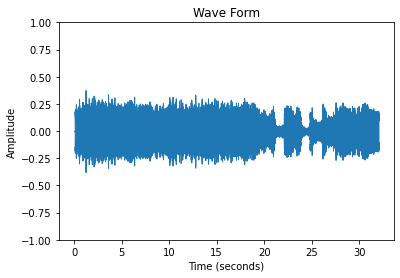

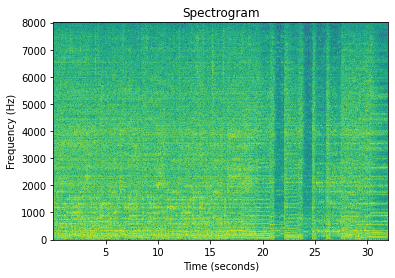

In [4]:
path      = "Recordings/Song/song_"
file_type = "Song"

song_f = load_file(file_type, path, 1)

## 2) Fire Alarm
### https://www.youtube.com/watch?v=QYBVHJm6tS4&ab_channel=BonzaiBopfest

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------
File Type:     Fire_Alarm
Num Files:     20
Samples:       512000
Sampling rate: 16000
-----------------


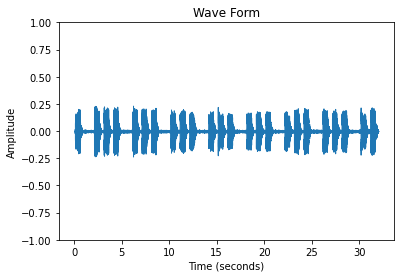

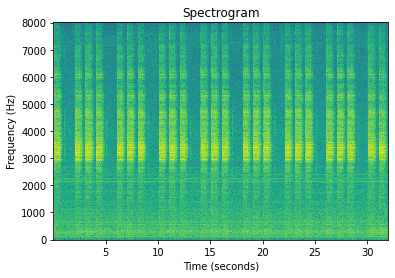

In [5]:
path      = "Recordings/Fire_Alarm/fire_alarm_"
file_type = "Fire_Alarm"

fire_alarm_f = load_file(file_type, path, 0)

## 3) Vacuum

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------
File Type:     Vacuum
Num Files:     20
Samples:       512000
Sampling rate: 16000
-----------------


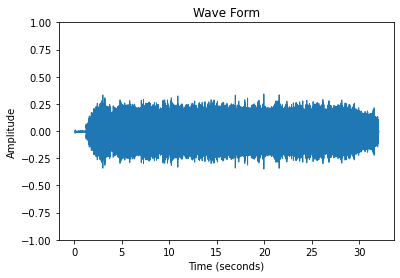

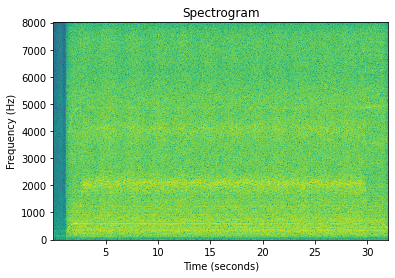

In [6]:
path      = "Recordings/Vacuum/vacuum_"
file_type = "Vacuum"

vacuum_f = load_file(file_type, path, 0)

## 4) Microwave

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------
File Type:     Microwave
Num Files:     20
Samples:       512000
Sampling rate: 16000
-----------------


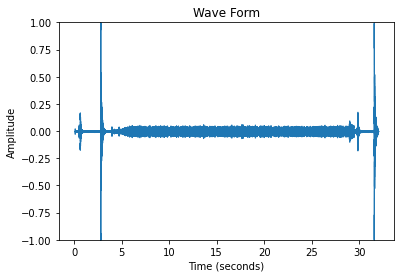

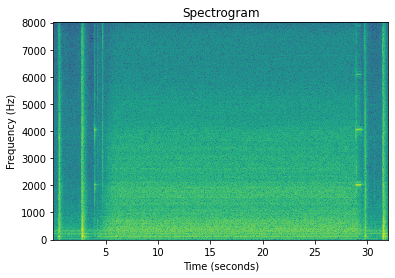

In [7]:
path      = "Recordings/Microwave/microwave_"
file_type = "Microwave"

microwave_f = load_file(file_type, path, 0)

## 5) Blender

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------
File Type:     Blender
Num Files:     20
Samples:       512000
Sampling rate: 16000
-----------------


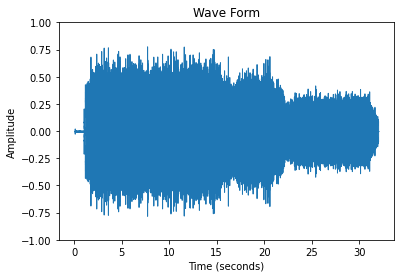

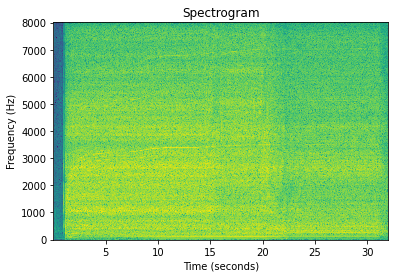

In [8]:
path      = "Recordings/Blender/blender_"
file_type = "Blender"

blender_f = load_file(file_type, path, 0)

## 6) Control 

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------
File Type:     Control
Num Files:     20
Samples:       512000
Sampling rate: 16000
-----------------


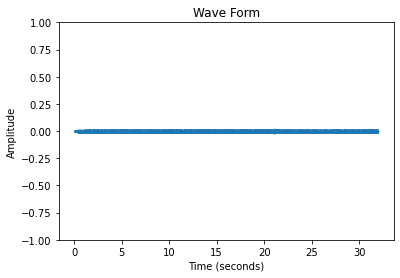

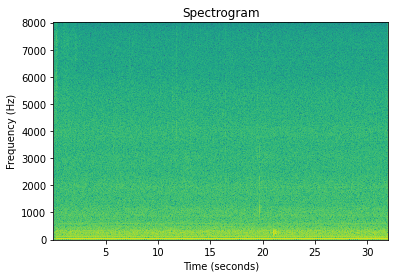

In [9]:
path      = "Recordings/Control/control_"
file_type = "Control"

control_f = load_file(file_type, path, 0)

# <ins>Pre-Processing</ins> (5%)

## 1) Calculate FFT

Class: Song


  0%|          | 0/20 [00:00<?, ?it/s]

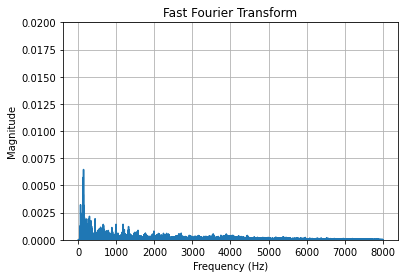

Class: Fire_Alarm


  0%|          | 0/20 [00:00<?, ?it/s]

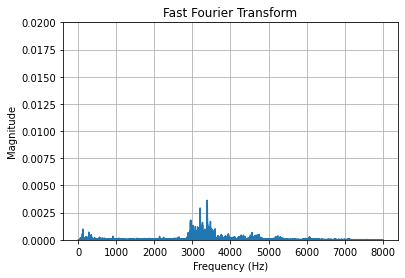

Class: Vacuum


  0%|          | 0/20 [00:00<?, ?it/s]

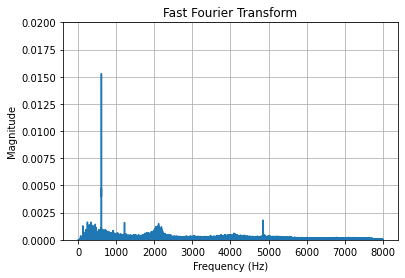

Class: Microwave


  0%|          | 0/20 [00:00<?, ?it/s]

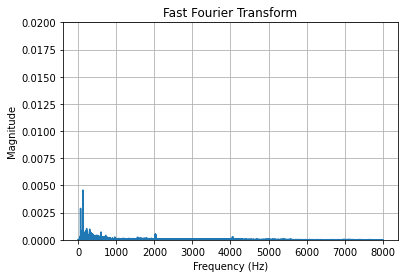

Class: Blender


  0%|          | 0/20 [00:00<?, ?it/s]

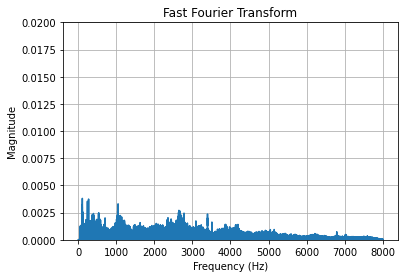

Class: Control


  0%|          | 0/20 [00:00<?, ?it/s]

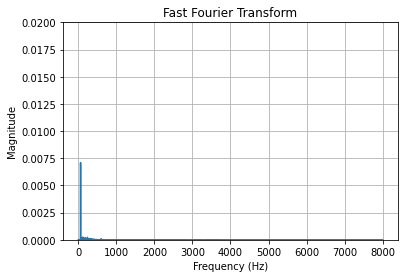

In [10]:
print("Class: " + song_f.file_type)
song_f.create_fft()

print("Class: " + fire_alarm_f.file_type)
fire_alarm_f.create_fft()

print("Class: " + vacuum_f.file_type)
vacuum_f.create_fft()

print("Class: " + microwave_f.file_type)
microwave_f.create_fft()

print("Class: " + blender_f.file_type)
blender_f.create_fft()

print("Class: " + control_f.file_type)
control_f.create_fft()

## 2) Frequency Cleaning

1925
Class: Song


  0%|          | 0/20 [00:00<?, ?it/s]

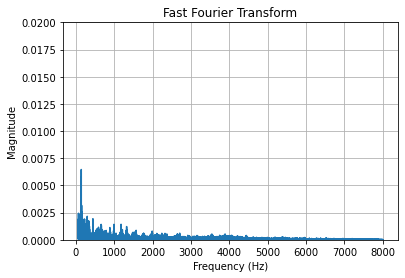

Class: Fire_Alarm


  0%|          | 0/20 [00:00<?, ?it/s]

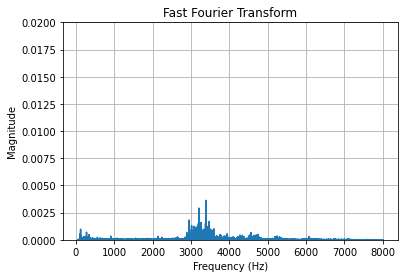

Class: Vacuum


  0%|          | 0/20 [00:00<?, ?it/s]

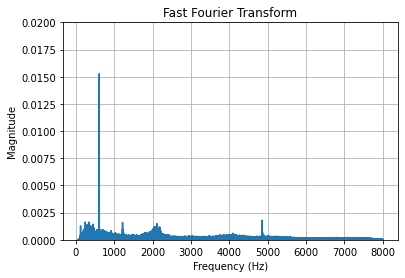

Class: Microwave


  0%|          | 0/20 [00:00<?, ?it/s]

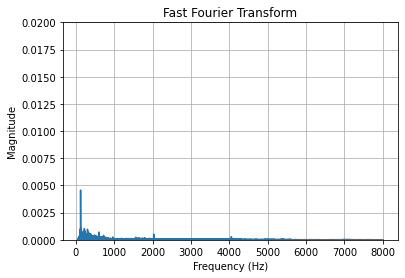

Class: Blender


  0%|          | 0/20 [00:00<?, ?it/s]

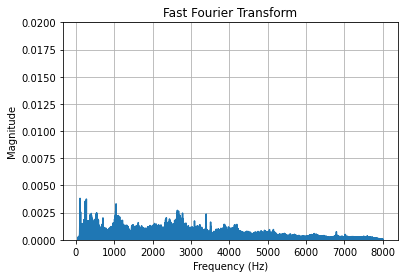

In [11]:
#remove this percentage of the low band frequencies from the control input from all the other input files
percent_rem = .10
tot         = sum(control_f.yf[0]) * percent_rem
cur         = 0
last        = 0

for one in range(len(control_f.yf[0])):
    if cur < tot:
        cur  += control_f.yf[0][one]
        last  = one
    else:
        break
        
print(last)

print("Class: " + song_f.file_type)
for file in trange(song_f.num_files):
    song_f.xf[file] = song_f.xf[file][last:]
    song_f.yf[file] = song_f.yf[file][last:]
song_f.graph_fft(0)

print("Class: " + fire_alarm_f.file_type)
for file in trange(fire_alarm_f.num_files):
    fire_alarm_f.xf[file] = fire_alarm_f.xf[file][last:]
    fire_alarm_f.yf[file] = fire_alarm_f.yf[file][last:]
fire_alarm_f.graph_fft(0)

print("Class: " + vacuum_f.file_type)
for file in trange(vacuum_f.num_files):
    vacuum_f.xf[file] = vacuum_f.xf[file][last:]
    vacuum_f.yf[file] = vacuum_f.yf[file][last:]
vacuum_f.graph_fft(0)

print("Class: " + microwave_f.file_type)
for file in trange(microwave_f.num_files):
    microwave_f.xf[file] = microwave_f.xf[file][last:]
    microwave_f.yf[file] = microwave_f.yf[file][last:]
microwave_f.graph_fft(0)

print("Class: " + blender_f.file_type)
for file in trange(blender_f.num_files):
    blender_f.xf[file] = blender_f.xf[file][last:]
    blender_f.yf[file] = blender_f.yf[file][last:]
blender_f.graph_fft(0)

## 3) Normalize the Data

In [12]:
print("Class: " + song_f.file_type)
song_f.normalize()

print("Class: " + fire_alarm_f.file_type)
fire_alarm_f.normalize()

print("Class: " + vacuum_f.file_type)
vacuum_f.normalize()

print("Class: " + microwave_f.file_type)
microwave_f.normalize()

print("Class: " + blender_f.file_type)
blender_f.normalize()

Class: Song


  0%|          | 0/20 [00:00<?, ?it/s]

Class: Fire_Alarm


  0%|          | 0/20 [00:00<?, ?it/s]

Class: Vacuum


  0%|          | 0/20 [00:00<?, ?it/s]

Class: Microwave


  0%|          | 0/20 [00:00<?, ?it/s]

Class: Blender


  0%|          | 0/20 [00:00<?, ?it/s]

# <ins>Feature Engineering / Extraction</ins> (60%)

## 1) Binning w/ 1 Window (15%)

Class: Song


  0%|          | 0/20 [00:00<?, ?it/s]

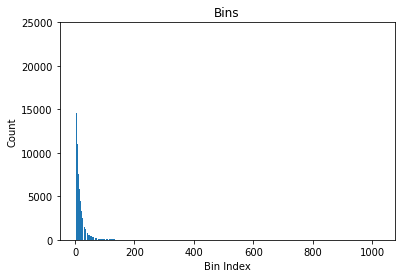

(20, 1024)
Class: Fire_Alarm


  0%|          | 0/20 [00:00<?, ?it/s]

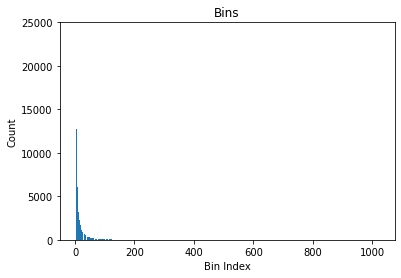

(20, 1024)
Class: Vacuum


  0%|          | 0/20 [00:00<?, ?it/s]

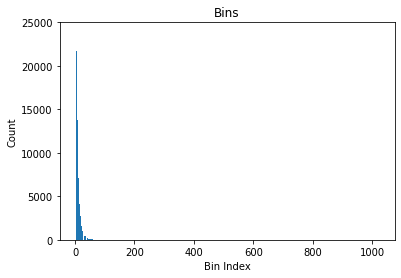

(20, 1024)
Class: Blender


  0%|          | 0/20 [00:00<?, ?it/s]

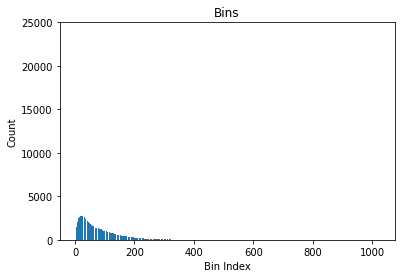

(20, 1024)
Class: Microwave


  0%|          | 0/20 [00:00<?, ?it/s]

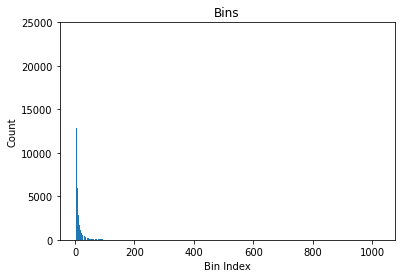

(20, 1024)


In [13]:
if BINNING:
    print("Class: " + song_f.file_type)
    song_f.create_bins_from_fft()   
    print(np.shape(song_f.bins))

    print("Class: " + fire_alarm_f.file_type)
    fire_alarm_f.create_bins_from_fft()
    print(np.shape(song_f.bins))

    print("Class: " + vacuum_f.file_type)
    vacuum_f.create_bins_from_fft()
    print(np.shape(song_f.bins))

    print("Class: " + blender_f.file_type)
    blender_f.create_bins_from_fft()
    print(np.shape(song_f.bins))

    print("Class: " + microwave_f.file_type)
    microwave_f.create_bins_from_fft()
    print(np.shape(song_f.bins))

## 2) Binning w/ Multiple Windows (15%)

Class: Song


  0%|          | 0/20 [00:00<?, ?it/s]

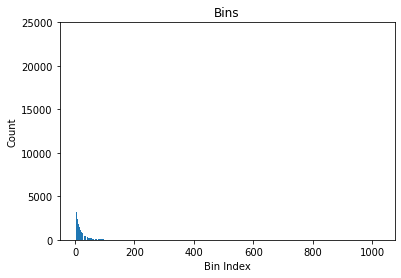

(160, 1024)
Class: Fire_Alarm


  0%|          | 0/20 [00:00<?, ?it/s]

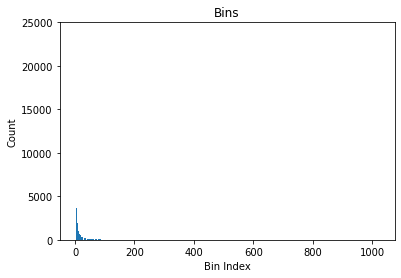

(160, 1024)
Class: Vacuum


  0%|          | 0/20 [00:00<?, ?it/s]

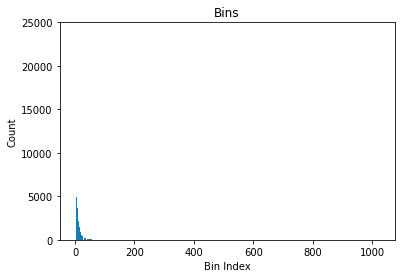

(160, 1024)
Class: Blender


  0%|          | 0/20 [00:00<?, ?it/s]

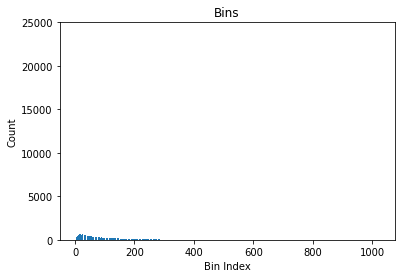

(160, 1024)
Class: Microwave


  0%|          | 0/20 [00:00<?, ?it/s]

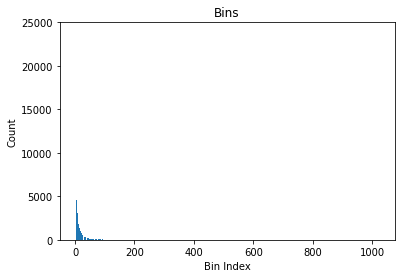

(160, 1024)


In [14]:
if BINNING_WINDOWED:
    print("Class: " + song_f.file_type)
    song_f.create_windowed_bins_from_fft()   
    print(np.shape(song_f.bin_windows))

    print("Class: " + fire_alarm_f.file_type)
    fire_alarm_f.create_windowed_bins_from_fft()
    print(np.shape(fire_alarm_f.bin_windows))

    print("Class: " + vacuum_f.file_type)
    vacuum_f.create_windowed_bins_from_fft()
    print(np.shape(vacuum_f.bin_windows))

    print("Class: " + blender_f.file_type)
    blender_f.create_windowed_bins_from_fft()
    print(np.shape(blender_f.bin_windows))

    print("Class: " + microwave_f.file_type)
    microwave_f.create_windowed_bins_from_fft()
    print(np.shape(microwave_f.bin_windows))

## 3) Domain-Specific Features w/ 1 Window (15%)

Class: Song


  0%|          | 0/20 [00:00<?, ?it/s]

Class: Fire_Alarm


  0%|          | 0/20 [00:00<?, ?it/s]

Class: Vacuum


  0%|          | 0/20 [00:00<?, ?it/s]

Class: Microwave


  0%|          | 0/20 [00:00<?, ?it/s]

Class: Blender


  0%|          | 0/20 [00:00<?, ?it/s]

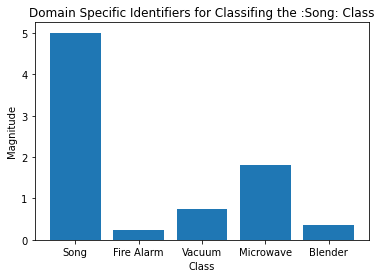

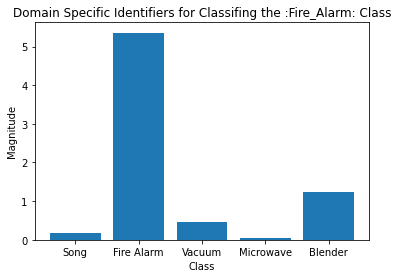

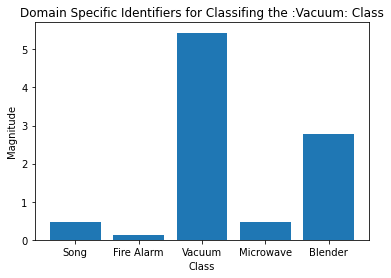

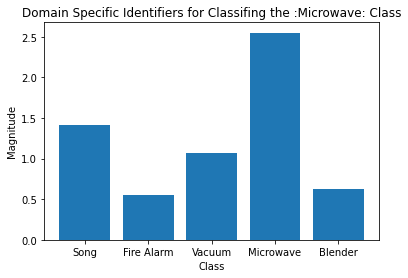

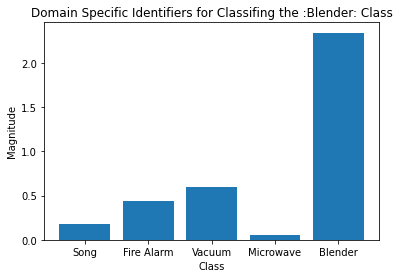

In [15]:
if DOMAIN_SPECIFIC_FEATURES:
    # Song
    # frequency range 127 Hz - 135 Hz

    # Fire_Alarm
    # frequency range 3385 Hz - 3395 Hz

    # Vacuum
    # frequency range 605 Hz - 606 Hz 

    # Microwave
    # frequency range 119.75 Hz - 120.25 Hz

    # Blender
    # frequency range 3630 Hz - 3640 Hz

    freq = [[127, 135], [3385, 3395], [605, 606], [119.75, 120.25], [3630, 3640]]

    print("Class: " + song_f.file_type)
    song_f.create_domain_spec_f(freq)

    print("Class: " + fire_alarm_f.file_type)
    fire_alarm_f.create_domain_spec_f(freq)

    print("Class: " + vacuum_f.file_type)
    vacuum_f.create_domain_spec_f(freq)

    print("Class: " + microwave_f.file_type)
    microwave_f.create_domain_spec_f(freq)

    print("Class: " + blender_f.file_type)
    blender_f.create_domain_spec_f(freq)
    
    def calc_and_graph_domain_spec_frequencies(avg_freq_l, idx, file_type):
        l = []

        for spec_class in avg_freq_l:
            avg = 0
            
            for file in spec_class:
                avg += file[idx]
            l.append(avg)

        plt.bar(["Song", "Fire Alarm", "Vacuum", "Microwave", "Blender"], l)
        plt.title("Domain Specific Identifiers for Classifing the :" + file_type + ": Class")
        plt.xlabel("Class")
        plt.ylabel("Magnitude")
        plt.show()

    avg_freq_l = [song_f.domain_spec_f, 
                  fire_alarm_f.domain_spec_f, 
                  vacuum_f.domain_spec_f, 
                  microwave_f.domain_spec_f, 
                  blender_f.domain_spec_f]

    calc_and_graph_domain_spec_frequencies(avg_freq_l, 0, song_f.file_type)
    calc_and_graph_domain_spec_frequencies(avg_freq_l, 1, fire_alarm_f.file_type)
    calc_and_graph_domain_spec_frequencies(avg_freq_l, 2, vacuum_f.file_type)
    calc_and_graph_domain_spec_frequencies(avg_freq_l, 3, microwave_f.file_type)
    calc_and_graph_domain_spec_frequencies(avg_freq_l, 4, blender_f.file_type)

## 4) Domain-Specific Features w/ Multiple Windows (15%)

Class: Song


  0%|          | 0/20 [00:00<?, ?it/s]

Class: Fire_Alarm


  0%|          | 0/20 [00:00<?, ?it/s]

Class: Vacuum


  0%|          | 0/20 [00:00<?, ?it/s]

Class: Microwave


  0%|          | 0/20 [00:00<?, ?it/s]

Class: Blender


  0%|          | 0/20 [00:00<?, ?it/s]

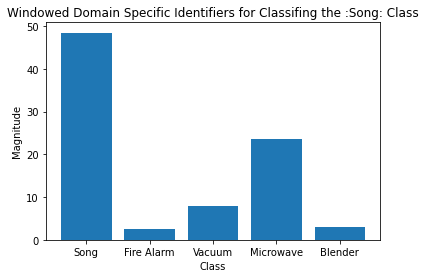

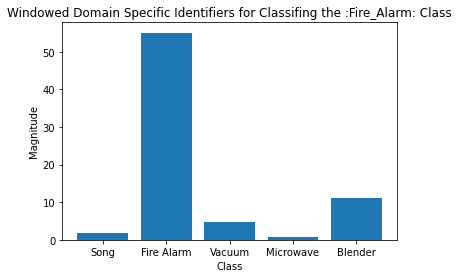

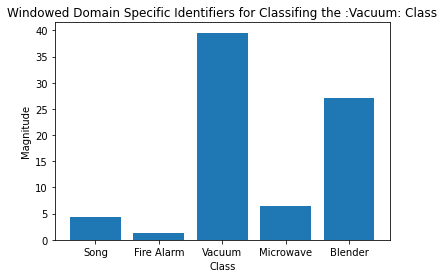

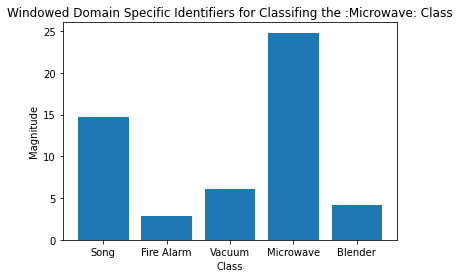

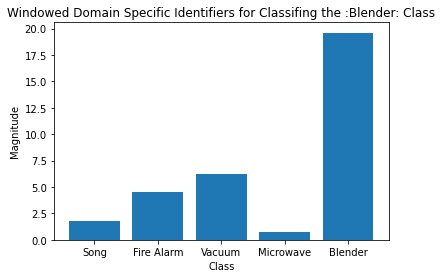

In [16]:
if DOMAIN_SPECIFIC_FEATURES_WINDOWED:
    # Song
    # frequency range 127 Hz - 135 Hz

    # Fire_Alarm
    # frequency range 3385 Hz - 3395 Hz

    # Vacuum
    # frequency range 605 Hz - 606 Hz 

    # Microwave
    # frequency range 119.75 Hz - 120.25 Hz

    # Blender
    # frequency range 3630 Hz - 3640 Hz
    freq = [[127, 135], [3385, 3395], [605, 606], [119.75, 120.25], [3630, 3640]]

    print("Class: " + song_f.file_type)
    song_f.create_windowed_domain_spec_f(freq)

    print("Class: " + fire_alarm_f.file_type)
    fire_alarm_f.create_windowed_domain_spec_f(freq)

    print("Class: " + vacuum_f.file_type)
    vacuum_f.create_windowed_domain_spec_f(freq)

    print("Class: " + microwave_f.file_type)
    microwave_f.create_windowed_domain_spec_f(freq)

    print("Class: " + blender_f.file_type)
    blender_f.create_windowed_domain_spec_f(freq)
    
    def calc_and_graph_domain_spec_frequencies(avg_freq_l, idx, file_type):
        l = []

        for spec_class in avg_freq_l:
            avg = 0

            for file in spec_class:
                avg += file[idx]
            l.append(avg)

        plt.bar(["Song", "Fire Alarm", "Vacuum", "Microwave", "Blender"], l)
        plt.title("Windowed Domain Specific Identifiers for Classifing the :" + file_type + ": Class")
        plt.xlabel("Class")
        plt.ylabel("Magnitude")
        plt.show()

    avg_freq_l = [song_f.domain_spec_f_windows, 
                  fire_alarm_f.domain_spec_f_windows, 
                  vacuum_f.domain_spec_f_windows, 
                  microwave_f.domain_spec_f_windows, 
                  blender_f.domain_spec_f_windows]

    calc_and_graph_domain_spec_frequencies(avg_freq_l, 0, song_f.file_type)
    calc_and_graph_domain_spec_frequencies(avg_freq_l, 1, fire_alarm_f.file_type)
    calc_and_graph_domain_spec_frequencies(avg_freq_l, 2, vacuum_f.file_type)
    calc_and_graph_domain_spec_frequencies(avg_freq_l, 3, microwave_f.file_type)
    calc_and_graph_domain_spec_frequencies(avg_freq_l, 4, blender_f.file_type)

# Training Model / Accuracy Scores

In [17]:
def train_model(data, filename):
    #split the data 70/30
    X = pd.DataFrame(data['data'])
    X_train, X_test, y_train, y_test = train_test_split(X, data['target'], test_size=.30, random_state=42)   
    
    n_clusters = len(np.unique(y_train))
    clf = KMeans(n_clusters = n_clusters, random_state=42)
    clf.fit(X_train)
    y_labels_train = clf.labels_
    y_labels_test = clf.predict(X_test)
    X_train['km_clust'] = y_labels_train
    X_test['km_clust'] = y_labels_test
    
    # save clf model to disk
    with open("saved_models/" + filename + "_clf_model.pkl", "wb") as f:
        pickle.dump(clf, f)

    #train the model
    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)
    
    # save the model to disk
    with open("saved_models/" + filename + "_model.pkl", "wb") as f:
        pickle.dump(model, f)
        
    # Accuracy Results
    cv_scores = cross_val_score(model, X_train, y_train, cv=10)
    print('Average Cross Validation Score from Training:', cv_scores.mean(), sep='\n', end='\n\n\n')

    #testing the model
    ypred = model.predict(X_test)
    cm    = confusion_matrix(y_test, ypred)
    cr    = classification_report(y_test, ypred)

    print('Confusion Matrix:', cm, sep='\n', end='\n\n\n')
    print('Test Statistics:', cr, sep='\n', end='\n\n\n')

    print('Testing Accuracy:', accuracy_score(y_test, ypred))

## 1) Train Binning w/ 1 Window

In [18]:
if BINNING:
    bins   = []
    target = []

    # convert data
    print("Class: " + song_f.file_type)
    bins.extend(song_f.bins)
    target.extend(['      song'] * song_f.num_files)

    print("Class: " + fire_alarm_f.file_type)
    bins.extend(fire_alarm_f.bins)
    target.extend(['fire_alarm'] * fire_alarm_f.num_files)

    print("Class: " + vacuum_f.file_type)
    bins.extend(vacuum_f.bins)
    target.extend(['    vacuum'] * vacuum_f.num_files)

    print("Class: " + microwave_f.file_type)
    bins.extend(microwave_f.bins)
    target.extend([' microwave'] * microwave_f.num_files)

    print("Class: " + blender_f.file_type)
    bins.extend(blender_f.bins)
    target.extend(['   blender'] * blender_f.num_files)

    bins_dict = {'data': bins, 'target': target}

    # checking shape
    print(" ")
    print(np.shape(bins_dict['data']))
    print(np.shape(bins_dict['target']))
    print(np.shape(list(chain.from_iterable(bins_dict['data']))))
    print(" ")

    # training
    train_model(bins_dict, 'bin_1_window')

Class: Song
Class: Fire_Alarm
Class: Vacuum
Class: Microwave
Class: Blender
 
(100, 1024)
(100,)
(102400,)
 
Average Cross Validation Score from Training:
0.9285714285714286


Confusion Matrix:
[[6 0 0 0 1]
 [1 5 0 0 0]
 [0 1 4 0 0]
 [0 0 0 6 0]
 [0 0 0 0 6]]


Test Statistics:
              precision    recall  f1-score   support

        song       0.86      0.86      0.86         7
      vacuum       0.83      0.83      0.83         6
     blender       1.00      0.80      0.89         5
   microwave       1.00      1.00      1.00         6
  fire_alarm       0.86      1.00      0.92         6

    accuracy                           0.90        30
   macro avg       0.91      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30



Testing Accuracy: 0.9


## 2) Train Binning w/ Multiple Windows

In [19]:
if BINNING_WINDOWED:
    bin_windows = []
    target      = []

    # convert data
    print("Class: " + song_f.file_type)
    bin_windows.extend(song_f.bin_windows)
    target.extend(['      song'] * len(song_f.bin_windows))

    print("Class: " + fire_alarm_f.file_type)
    bin_windows.extend(fire_alarm_f.bin_windows)
    target.extend(['fire_alarm'] * len(fire_alarm_f.bin_windows))

    print("Class: " + vacuum_f.file_type)
    bin_windows.extend(vacuum_f.bin_windows)
    target.extend(['    vacuum'] * len(vacuum_f.bin_windows))

    print("Class: " + microwave_f.file_type)
    bin_windows.extend(microwave_f.bin_windows)
    target.extend([' microwave'] * len(microwave_f.bin_windows))

    print("Class: " + blender_f.file_type)
    bin_windows.extend(blender_f.bin_windows)
    target.extend(['   blender'] * len(blender_f.bin_windows))

    bin_windows_dict = {'data': bin_windows, 'target': target}

    # checking shape
    print(" ")
    print(np.shape(bin_windows_dict['data']))
    print(np.shape(bin_windows_dict['target']))
    print(np.shape(list(chain.from_iterable(bin_windows_dict['data']))))
    print(" ")

    # training
    train_model(bin_windows_dict, 'bin_multi_window')

Class: Song
Class: Fire_Alarm
Class: Vacuum
Class: Microwave
Class: Blender
 
(800, 1024)
(800,)
(819200,)
 
Average Cross Validation Score from Training:
0.8607142857142858


Confusion Matrix:
[[44  1  0  0  7]
 [ 0 39  5  1  0]
 [ 0  8 44  0  0]
 [ 1  2  0 43  0]
 [ 1  0  0  0 44]]


Test Statistics:
              precision    recall  f1-score   support

        song       0.96      0.85      0.90        52
      vacuum       0.78      0.87      0.82        45
     blender       0.90      0.85      0.87        52
   microwave       0.98      0.93      0.96        46
  fire_alarm       0.86      0.98      0.92        45

    accuracy                           0.89       240
   macro avg       0.89      0.89      0.89       240
weighted avg       0.90      0.89      0.89       240



Testing Accuracy: 0.8916666666666667


## 3) Train Domain-Specific Features w/ 1 Window

In [20]:
if DOMAIN_SPECIFIC_FEATURES:
    domain_spec_f = []
    target        = []

    # convert data
    print("Class: " + song_f.file_type)
    domain_spec_f.extend(song_f.domain_spec_f)
    target.extend(['      song'] * len(song_f.domain_spec_f))

    print("Class: " + fire_alarm_f.file_type)
    domain_spec_f.extend(fire_alarm_f.domain_spec_f)
    target.extend(['fire_alarm'] * len(fire_alarm_f.domain_spec_f))

    print("Class: " + vacuum_f.file_type)
    domain_spec_f.extend(vacuum_f.domain_spec_f)
    target.extend(['    vacuum'] * len(vacuum_f.domain_spec_f))

    print("Class: " + microwave_f.file_type)
    domain_spec_f.extend(microwave_f.domain_spec_f)
    target.extend([' microwave'] * len(microwave_f.domain_spec_f))

    print("Class: " + blender_f.file_type)
    domain_spec_f.extend(blender_f.domain_spec_f)
    target.extend(['   blender'] * len(blender_f.domain_spec_f))

    domain_spec_f_dict = {'data': domain_spec_f, 'target': target}

    # checking shape
    print(" ")
    print(np.shape(domain_spec_f_dict['data']))
    print(np.shape(domain_spec_f_dict['target']))
    print(np.shape(list(chain.from_iterable(domain_spec_f_dict['data']))))
    print(" ")

    # training
    train_model(domain_spec_f_dict, 'domain_spec_f_1_window')

Class: Song
Class: Fire_Alarm
Class: Vacuum
Class: Microwave
Class: Blender
 
(100, 5)
(100,)
(500,)
 
Average Cross Validation Score from Training:
0.9428571428571428


Confusion Matrix:
[[6 0 0 1 0]
 [0 3 2 1 0]
 [0 0 5 0 0]
 [0 0 0 6 0]
 [0 0 0 0 6]]


Test Statistics:
              precision    recall  f1-score   support

        song       1.00      0.86      0.92         7
      vacuum       1.00      0.50      0.67         6
     blender       0.71      1.00      0.83         5
   microwave       0.75      1.00      0.86         6
  fire_alarm       1.00      1.00      1.00         6

    accuracy                           0.87        30
   macro avg       0.89      0.87      0.86        30
weighted avg       0.90      0.87      0.86        30



Testing Accuracy: 0.8666666666666667


## 4) Train Domain-Specific Features w/ Multiple Windows

In [21]:
if DOMAIN_SPECIFIC_FEATURES_WINDOWED:
    domain_spec_f_windows = []
    target                = []

    # convert data
    print("Class: " + song_f.file_type)
    domain_spec_f_windows.extend(song_f.domain_spec_f_windows)
    target.extend(['      song'] * len(song_f.domain_spec_f_windows))

    print("Class: " + fire_alarm_f.file_type)
    domain_spec_f_windows.extend(fire_alarm_f.domain_spec_f_windows)
    target.extend(['fire_alarm'] * len(fire_alarm_f.domain_spec_f_windows))

    print("Class: " + vacuum_f.file_type)
    domain_spec_f_windows.extend(vacuum_f.domain_spec_f_windows)
    target.extend(['    vacuum'] * len(vacuum_f.domain_spec_f_windows))

    print("Class: " + microwave_f.file_type)
    domain_spec_f_windows.extend(microwave_f.domain_spec_f_windows)
    target.extend([' microwave'] * len(microwave_f.domain_spec_f_windows))

    print("Class: " + blender_f.file_type)
    domain_spec_f_windows.extend(blender_f.domain_spec_f_windows)
    target.extend(['   blender'] * len(blender_f.domain_spec_f_windows))

    domain_spec_f_window_dict = {'data': domain_spec_f_windows, 'target': target}

    # checking shape
    print(" ")
    print(np.shape(domain_spec_f_window_dict['data']))
    print(np.shape(domain_spec_f_window_dict['target']))
    print(np.shape(list(chain.from_iterable(domain_spec_f_window_dict['data']))))
    print(" ")

    # training
    train_model(domain_spec_f_window_dict, 'domain_spec_f_multi_window')

Class: Song
Class: Fire_Alarm
Class: Vacuum
Class: Microwave
Class: Blender
 
(800, 5)
(800,)
(4000,)
 
Average Cross Validation Score from Training:
0.9


Confusion Matrix:
[[47  0  0  5  0]
 [ 0 44  0  1  0]
 [ 0 10 39  2  1]
 [ 6  0  0 40  0]
 [ 0  0  0  0 45]]


Test Statistics:
              precision    recall  f1-score   support

        song       0.89      0.90      0.90        52
      vacuum       0.81      0.98      0.89        45
     blender       1.00      0.75      0.86        52
   microwave       0.83      0.87      0.85        46
  fire_alarm       0.98      1.00      0.99        45

    accuracy                           0.90       240
   macro avg       0.90      0.90      0.90       240
weighted avg       0.90      0.90      0.89       240



Testing Accuracy: 0.8958333333333334
